In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

Trial 20 Complete [00h 01m 33s]
val_loss: 0.0007744653266854584

Best val_loss So Far: 0.00026957818772643805
Total elapsed time: 00h 32m 38s
Ticker: TSLA
The hyperparameter search is complete. The optimal number of layers is 3.
Layer 1: 160 units
Layer 2: 352 units
Layer 3: 160 units
The optimal learning rate for the optimizer is 0.00034786388011680107.
Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 0.0179 - val_loss: 0.0051
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 0.0014 - val_loss: 0.0052
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 8.5237e-04 - val_loss: 0.0017
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 8.3354e-04 - val_loss: 0.0032
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 8.1497e-04 - val_loss: 0.0012
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━

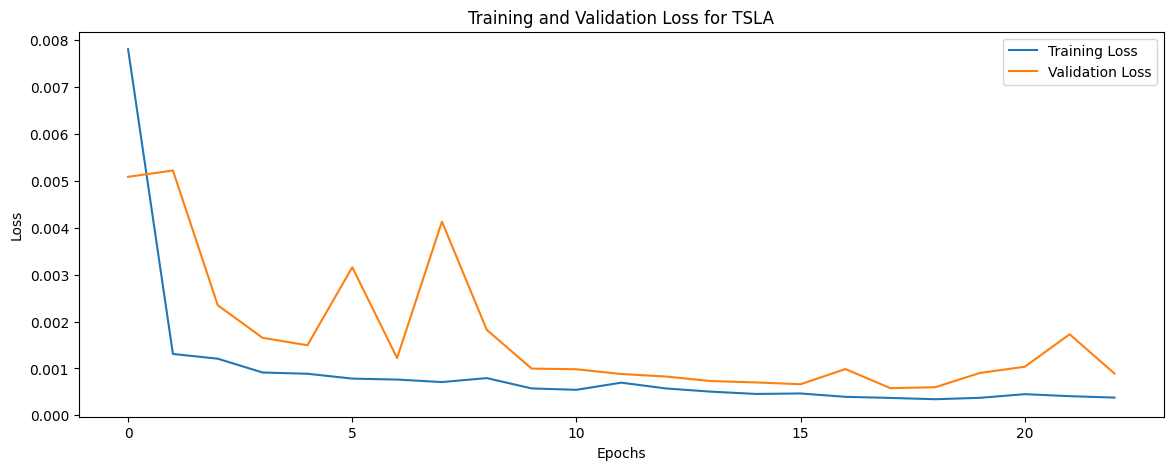

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


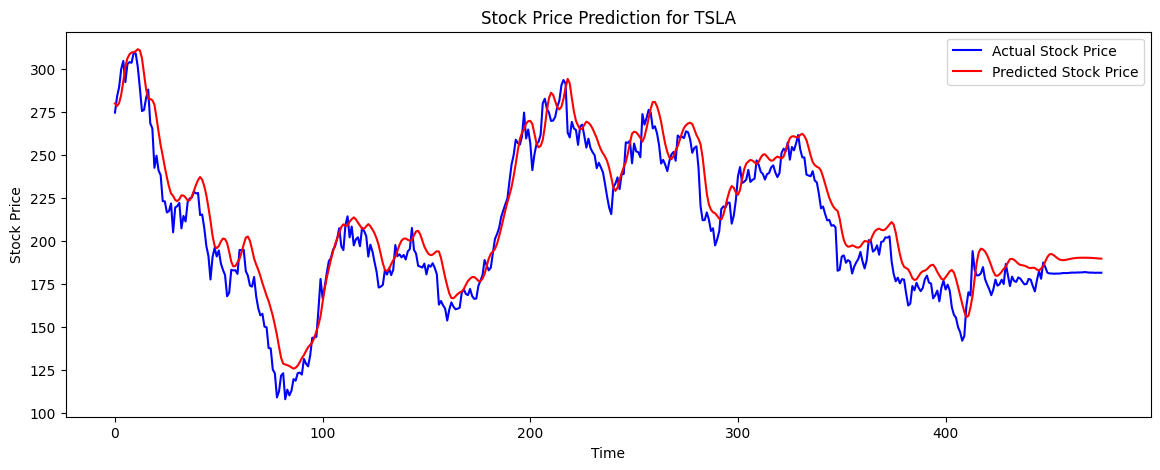

In [2]:
# Load the dataset
file_path = 'D:\\Github Mikezxc\\Big-data-stock-real-time-platform\\merged_data_with_ma.csv'
merged_df = pd.read_csv(file_path)

# Normalize data
price_scaler = MinMaxScaler()
merged_df[['close']] = price_scaler.fit_transform(merged_df[['close']])

feature_scaler = MinMaxScaler()
merged_df[['MA30', 'MA90']] = feature_scaler.fit_transform(merged_df[['MA30', 'MA90']])

# Prepare sequences for LSTM
def create_sequences(df, time_steps=30):
    sequences = []
    labels = []
    for i in range(len(df) - time_steps):
        sequence = df[['close', 'MA30', 'MA90']].iloc[i:i+time_steps].values
        label = df['close'].iloc[i+time_steps]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define the LSTM HyperModel
class LSTMHyperModel(kt.HyperModel):
    def build(self, hp):
        model = Sequential()
        for i in range(hp.Int('num_layers', 1, 3)):
            model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), 
                           return_sequences=(i != hp.Int('num_layers', 1, 3) - 1), input_shape=(time_steps, 3)))
        model.add(Dense(1))  # Output layer should match the number of features
        model.compile(optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
            loss='mean_squared_error')
        return model

# Train and evaluate the model for each ticker
tickers = merged_df['ticker'].unique()

for ticker in tickers:
    ticker_df = merged_df[merged_df['ticker'] == ticker].dropna()
    
    # Create sequences and labels
    time_steps = 30
    X, y = create_sequences(ticker_df, time_steps)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Initialize RandomSearch Tuner
    tuner = kt.RandomSearch(
        LSTMHyperModel(),
        objective='val_loss',
        max_trials=20,
        executions_per_trial=1,
        directory='my_dir',
        project_name=f'lstm_stock_model_{ticker}'
    )

    # Perform hyperparameter search
    tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

    # Retrieve the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Ticker: {ticker}")
    print(f"The hyperparameter search is complete. The optimal number of layers is {best_hps.get('num_layers')}.")
    for i in range(best_hps.get('num_layers')):
        print(f"Layer {i + 1}: {best_hps.get(f'units_{i}')} units")
    print(f"The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.")

    # Build the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hps)

    # Train the model
    history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

    # Save the model
    model.save(f'/mnt/data/lstm_stock_model_best_{ticker}.h5')

    # Save the scalers
    joblib.dump(price_scaler, f'/mnt/data/{ticker}_price_scaler.pkl')
    joblib.dump(feature_scaler, f'/mnt/data/{ticker}_feature_scaler.pkl')

    # Plot the training and validation loss
    plt.figure(figsize=(14, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {ticker}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Make predictions
    y_pred = model.predict(X_test)

    # Inverse transform the predictions and the actual values
    y_pred = price_scaler.inverse_transform(y_pred)
    y_test = price_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot the results
    plt.figure(figsize=(14, 5))
    plt.plot(y_test, color='blue', label='Actual Stock Price')
    plt.plot(y_pred, color='red', label='Predicted Stock Price')
    plt.title(f'Stock Price Prediction for {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [5]:
plot_data = []
# Plot the training and validation loss for each ticker
for data in plot_data:
    ticker = data['ticker']
    history = data['history']
    
    plt.figure(figsize=(14, 5))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {ticker}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot the actual vs predicted stock prices
    y_test = data['y_test']
    y_pred = data['y_pred']

    plt.figure(figsize=(14, 5))
    plt.plot(y_test, color='blue', label='Actual Stock Price')
    plt.plot(y_pred, color='red', label='Predicted Stock Price')
    plt.title(f'Stock Price Prediction for {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    